### RNN para la Serie Renta

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from datetime import timedelta

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

import tensorflow.keras as keras

import gc
gc.collect()

22

In [2]:
%matplotlib inline

In [2]:
ruta = 'datos-1.xlsx'

df= pd.read_excel(ruta,usecols="B")

In [3]:
indice = pd.date_range(start='1/01/2000', periods=288, freq='MS')
indice
RENTAdf =pd.DataFrame(df['I_Renta'].values,index=indice, columns=['I_Renta'])
type(RENTAdf)

pandas.core.frame.DataFrame

In [4]:
print(RENTAdf.head())

                 I_Renta
2000-01-01  5.584091e+05
2000-02-01  7.888136e+05
2000-03-01  4.086987e+05
2000-04-01  1.071977e+06
2000-05-01  5.108934e+05


#### RNN Regression

En esta ocasión nos centraremos en predecir el índice de renta 1 paso adelante

In [5]:
use_features = ['I_Renta'] # entrada continua
target = ['I_Renta'] # salida continua
n_steps_ahead = 1 # predicciones adelante

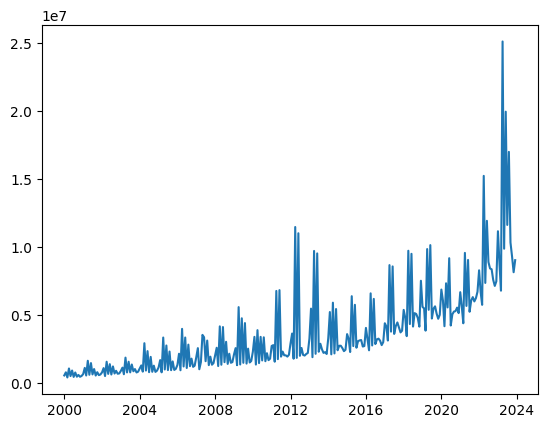

In [6]:
plt.plot(RENTAdf['I_Renta'])

#### Prueba de Estacionariedad

In [7]:
sample = RENTAdf['I_Renta']
adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(sample)

In [8]:
adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: 3.0004232365178196
p-value: 1.0,
N: 274, 
critical values: {'1%': -3.4544435065994437, '5%': -2.8721468827772774, '10%': -2.572422013959188}


Dado que el p-valor es más grande que 0.01, entonces no rechazamos el test a un nivel de confianza del 90%. Por lo tanto, podemos decir que la Serie del **Índice de Renta** no es estacionaria.

#### PACF para identificar el número de retardos necesarios h

In [9]:
pacf = sm.tsa.stattools.pacf(RENTAdf[use_features], nlags=24)

In [10]:
T = len(RENTAdf[use_features])

sig_test = lambda tau_h: np.abs(tau_h) > 2.58/np.sqrt(T)

In [11]:
for i in range(len(pacf)):
    if sig_test(pacf[i]) == False:
        n_steps = i - 1
        print('n_steps set to', n_steps)
        break

n_steps set to 3


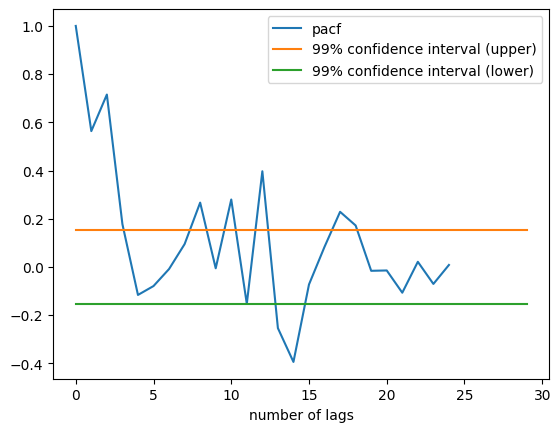

In [12]:
plt.plot(pacf, label='pacf')
plt.plot([2.58/np.sqrt(T)]*30, label='99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(T)]*30, label='99% confidence interval (lower)')
plt.xlabel('number of lags')
plt.legend();

#### Ahora estabilizamos la varianza y hacemos diferenciación ordinaria

In [13]:
lRENTAdf=np.log(RENTAdf)
print(lRENTAdf)

              I_Renta
2000-01-01  13.232847
2000-02-01  13.578285
2000-03-01  12.920734
2000-04-01  13.885015
2000-05-01  13.143916
...               ...
2023-08-01  16.649340
2023-09-01  16.151353
2023-10-01  16.048914
2023-11-01  15.914070
2023-12-01  16.017297

[288 rows x 1 columns]


In [14]:
lRENTAdf=np.log(RENTAdf)
dlRENTAdf=lRENTAdf.diff()

In [15]:
print(lRENTAdf.tail(26))

              I_Renta
2021-11-01  15.648512
2021-12-01  15.720495
2022-01-01  15.931213
2022-02-01  15.711189
2022-03-01  15.565616
2022-04-01  16.539723
2022-05-01  15.812553
2022-06-01  16.295108
2022-07-01  16.001981
2022-08-01  15.947456
2022-09-01  15.940121
2022-10-01  15.843433
2022-11-01  15.782214
2022-12-01  15.828285
2023-01-01  16.228791
2023-02-01  15.978901
2023-03-01  15.731851
2023-04-01  17.039757
2023-05-01  16.106477
2023-06-01  16.809609
2023-07-01  16.269473
2023-08-01  16.649340
2023-09-01  16.151353
2023-10-01  16.048914
2023-11-01  15.914070
2023-12-01  16.017297


In [16]:
dlRENTAdf=dlRENTAdf[1:]

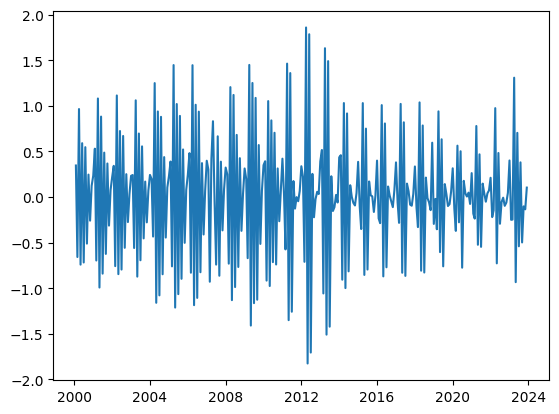

In [17]:
plt.plot(dlRENTAdf['I_Renta'])

#### Partición en conjunto de entrenamiento y conjunto de prueba

In [64]:
train_weight = 0.9
split = int(len(RENTAdf) * train_weight)

df_train = dlRENTAdf[use_features].iloc[0:259]
df_test = dlRENTAdf[use_features].iloc[259:]

#### Creando la componente estacional

In [65]:
date_time=indice
type(date_time)

pandas.core.indexes.datetimes.DatetimeIndex

In [66]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
timestamp_s

Index([ 946684800.0,  949363200.0,  951868800.0,  954547200.0,  957139200.0,
        959817600.0,  962409600.0,  965088000.0,  967766400.0,  970358400.0,
       ...
       1677628800.0, 1680307200.0, 1682899200.0, 1685577600.0, 1688169600.0,
       1690848000.0, 1693526400.0, 1696118400.0, 1698796800.0, 1701388800.0],
      dtype='float64', length=288)

In [67]:
# Periodos
from pandas import DataFrame
anio = 365.25 * 24 * 60 * 60  # segundos en un año

# Componentes estacionales anuales
Fourierdf=DataFrame()
Fourierdf['Year sin'] = np.sin(timestamp_s * (2 * np.pi / anio))
Fourierdf['Year cos'] = np.cos(timestamp_s * (2 * np.pi / anio))

##### Estandarización de los datos

Ahora, vamos a estandarizar los datos para evitar posibles dificultades en el ajuste del modelo. La estandarización se hace con relación al conjunto de entrenamiento.

In [68]:
mu = float(df_train.mean())
sigma = float(df_train.std())

stdize_input = lambda x: (x - mu) / sigma

df_train = df_train.apply(stdize_input)
df_test = df_test.apply(stdize_input)
Fourierdf['Year sin'] = Fourierdf['Year sin'].apply(stdize_input)
Fourierdf['Year cos'] = Fourierdf['Year cos'].apply(stdize_input)

C:\Users\Embag\AppData\Local\Temp\ipykernel_17136\3076620468.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu = float(df_train.mean())
C:\Users\Embag\AppData\Local\Temp\ipykernel_17136\3076620468.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma = float(df_train.std())


#### Creación de retardos 

In [69]:
n_steps=4
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

In [70]:
n_steps_ahead

1

In [71]:
x_train = get_lagged_features(df_train, n_steps, n_steps_ahead)
y_train =  df_train.values[n_steps + n_steps_ahead - 1:]
y_train_timestamps = df_train.index[n_steps + n_steps_ahead - 1:]

x_test = get_lagged_features(df_test, n_steps, n_steps_ahead)
y_test =  df_test.values[n_steps + n_steps_ahead - 1:]
y_test_timestamps = df_test.index[n_steps + n_steps_ahead - 1:]

In [73]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(255, 4, 1), (255, 1), (24, 4, 1), (24, 1)]


In [74]:
print(x_test)

[[[ 0.04420691]
  [-0.08707221]
  [ 0.04473754]
  [ 0.0899196 ]]

 [[-0.08707221]
  [ 0.04473754]
  [ 0.0899196 ]
  [ 0.28866666]]

 [[ 0.04473754]
  [ 0.0899196 ]
  [ 0.28866666]
  [-0.32840032]]

 [[ 0.0899196 ]
  [ 0.28866666]
  [-0.32840032]
  [-0.22174506]]

 [[ 0.28866666]
  [-0.32840032]
  [-0.22174506]
  [ 1.38227545]]

 [[-0.32840032]
  [-0.22174506]
  [ 1.38227545]
  [-1.05492345]]

 [[-0.22174506]
  [ 1.38227545]
  [-1.05492345]
  [ 0.67809206]]

 [[ 1.38227545]
  [-1.05492345]
  [ 0.67809206]
  [-0.43312605]]

 [[-1.05492345]
  [ 0.67809206]
  [-0.43312605]
  [-0.09131157]]

 [[ 0.67809206]
  [-0.43312605]
  [-0.09131157]
  [-0.02371001]]

 [[-0.43312605]
  [-0.09131157]
  [-0.02371001]
  [-0.15171344]]

 [[-0.09131157]
  [-0.02371001]
  [-0.15171344]
  [-0.10090095]]

 [[-0.02371001]
  [-0.15171344]
  [-0.10090095]
  [ 0.0527979 ]]

 [[-0.15171344]
  [-0.10090095]
  [ 0.0527979 ]
  [ 0.56055138]]

 [[-0.10090095]
  [ 0.0527979 ]
  [ 0.56055138]
  [-0.3711851 ]]

 [[ 0.0527

### Especificación del modelo

In [75]:
def SimpleRNN_(n_units = 10, l1_reg=0, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True, stateful=False))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def GRU_(n_units = 10, l1_reg=0, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def LSTM_(n_units = 10, l1_reg=0, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True)) 
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

Usaremos un tamaño del lote igual a 7 y 50 epochs tal como se hizo en las redes neuronales multicapa.

In [76]:
max_epochs = 50 
batch_size = 7

In [77]:
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10, min_delta=1e-7, restore_best_weights=True)

In [78]:
params = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

In [79]:
params

{'rnn': {'model': None,
  'function': <function __main__.SimpleRNN_(n_units=10, l1_reg=0, seed=0)>,
  'l1_reg': 0.0,
  'H': 20,
  'color': 'blue',
  'label': 'RNN'},
 'gru': {'model': None,
  'function': <function __main__.GRU_(n_units=10, l1_reg=0, seed=0)>,
  'l1_reg': 0.0,
  'H': 10,
  'color': 'orange',
  'label': 'GRU'},
 'lstm': {'model': None,
  'function': <function __main__.LSTM_(n_units=10, l1_reg=0, seed=0)>,
  'l1_reg': 0.0,
  'H': 10,
  'color': 'red',
  'label': 'LSTM'}}

#### Pre-entrenando los modelos

In [80]:
do_training=True

In [81]:
params.keys()

dict_keys(['rnn', 'gru', 'lstm'])

In [82]:
if do_training is False:
     for key in params.keys():
        params[key]['model']=keras.models.load_model('RNNs-RENTA-SAVED-' + key + '.hdf5')

#### Validación cruzada

In [ ]:
cross_val = True # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [32,64]
    l1_reg = [0.0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        print('Performing cross-validation. Model:', key)
        model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=params[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2)
        #from scikeras.wrappers import KerasClassifier, KerasRegressor
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

Performing cross-validation. Model: rnn
Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\Embag\AppData\Local\Temp\ipykernel_17136\3492471351.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=params[key]['function'], epochs=max_epochs,


Epoch 1/50
7/7 - 1s - loss: 5.0458 - 1s/epoch - 153ms/step
Epoch 2/50
7/7 - 0s - loss: 4.3375 - 16ms/epoch - 2ms/step
Epoch 3/50
7/7 - 0s - loss: 3.9260 - 14ms/epoch - 2ms/step
Epoch 4/50
7/7 - 0s - loss: 3.6570 - 14ms/epoch - 2ms/step
Epoch 5/50
7/7 - 0s - loss: 3.3980 - 15ms/epoch - 2ms/step
Epoch 6/50
7/7 - 0s - loss: 3.1574 - 12ms/epoch - 2ms/step
Epoch 7/50
7/7 - 0s - loss: 2.9532 - 18ms/epoch - 3ms/step
Epoch 8/50
7/7 - 0s - loss: 2.7267 - 12ms/epoch - 2ms/step
Epoch 9/50
7/7 - 0s - loss: 2.5768 - 646us/epoch - 92us/step
Epoch 10/50
7/7 - 0s - loss: 2.3675 - 14ms/epoch - 2ms/step
Epoch 11/50
7/7 - 0s - loss: 2.2032 - 15ms/epoch - 2ms/step
Epoch 12/50
7/7 - 0s - loss: 2.0447 - 0s/epoch - 0s/step
Epoch 13/50
7/7 - 0s - loss: 1.8995 - 2ms/epoch - 230us/step
Epoch 14/50
7/7 - 0s - loss: 1.7753 - 16ms/epoch - 2ms/step
Epoch 15/50
7/7 - 0s - loss: 1.6418 - 17ms/epoch - 2ms/step
Epoch 16/50
7/7 - 0s - loss: 1.5249 - 16ms/epoch - 2ms/step
Epoch 17/50
7/7 - 0s - loss: 1.3942 - 0s/epoch - 

### Ajustar el modelo con los mejores parámetros

In [104]:
if do_training is True:
    for key in params.keys():
        tf.random.set_seed(0)
        print('Training', key, 'model')
        model = params[key]['function'](params[key]['H'], params[key]['l1_reg'])
        model.fit(x_train, y_train, epochs=max_epochs, 
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params[key]['model'] = model

Training rnn model
Epoch 1/50
37/37 [==============================] - 1s 3ms/step - loss: 5.2900
Epoch 2/50
37/37 [==============================] - 0s 2ms/step - loss: 3.4916
Epoch 3/50
37/37 [==============================] - 0s 2ms/step - loss: 2.4798
Epoch 4/50
37/37 [==============================] - 0s 3ms/step - loss: 1.8327
Epoch 5/50
37/37 [==============================] - 0s 2ms/step - loss: 1.3817
Epoch 6/50
37/37 [==============================] - 0s 2ms/step - loss: 1.1457
Epoch 7/50
37/37 [==============================] - 0s 2ms/step - loss: 1.0135
Epoch 8/50
37/37 [==============================] - 0s 2ms/step - loss: 0.9165
Epoch 9/50
37/37 [==============================] - 0s 3ms/step - loss: 0.8359
Epoch 10/50
37/37 [==============================] - 0s 2ms/step - loss: 0.7669
Epoch 11/50
37/37 [==============================] - 0s 2ms/step - loss: 0.7071
Epoch 12/50
37/37 [==============================] - 0s 2ms/step - loss: 0.6550
Epoch 13/50
37/37 [===========

Podemos guardar los modelos ajustados

In [105]:
for key in params.keys():
    params[key]['model'].save('RNNs-RENTA-SAVED-' + key + '.hdf5', overwrite=True)  # creates a HDF5 file

#### Predicción

Ahora, con los modelos ajustados, podemos hacer la predicción un paso adelante 

In [106]:
for key in params.keys():
    model = params[key]['model']
    model.summary()
    
    params[key]['pred_train'] = model.predict(x_train, verbose=1)
    params[key]['MSE_train'] = mean_squared_error(y_train, params[key]['pred_train'])
    
    params[key]['pred_test'] = model.predict(x_test, verbose=1) 
    params[key]['MSE_test'] = mean_squared_error(y_test, params[key]['pred_test'])

Model: "sequential_675"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_104 (SimpleRNN)  (None, 32)                1088      
                                                                 
 dense_1761 (Dense)          (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 32ms/step
Model: "sequential_676"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_104 (GRU)               (None, 32)                3360      
                                                                 
 dense_1762 (Dense)          (None, 1)                 33        
                                        

### Rendimiento del modelo

In [107]:
print('training set:', len(y_train))
print('testing set:', len(y_test))

training set: 255
testing set: 24


In [108]:
print(params.keys())

dict_keys(['rnn', 'gru', 'lstm'])


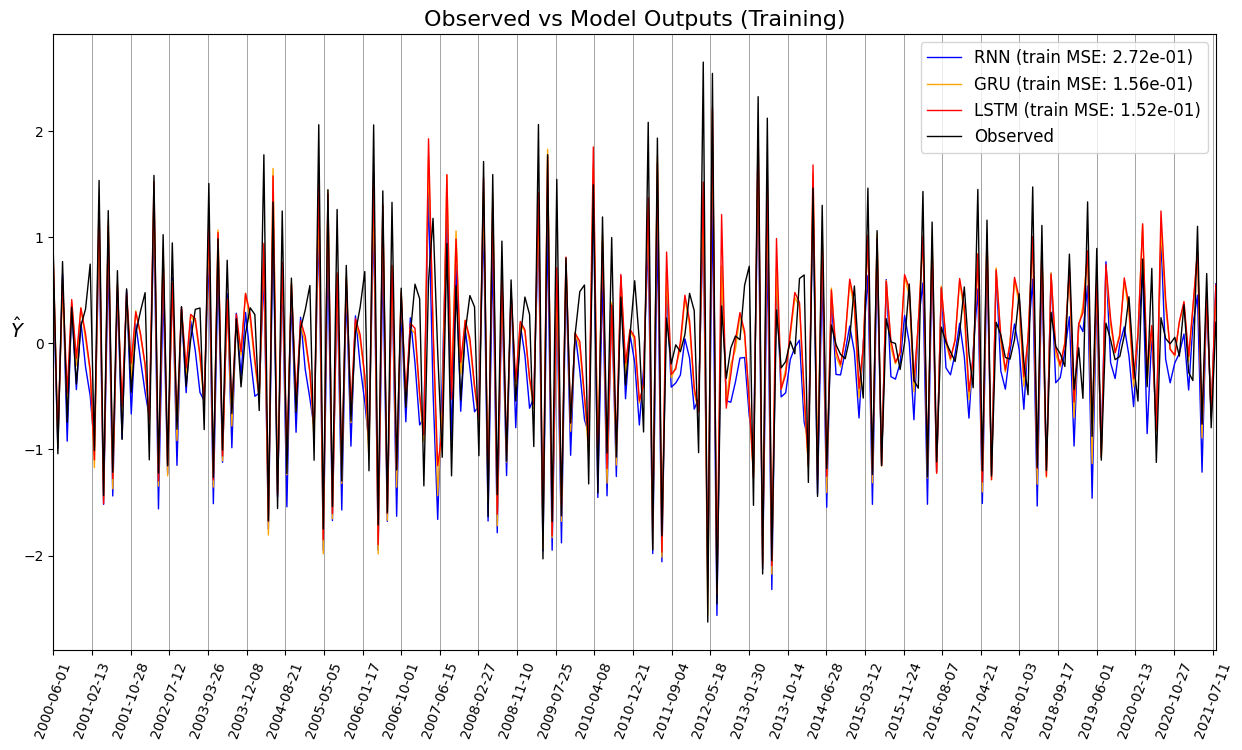

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

max_pts = 10**4
compare = params.keys()  # Ejemplo: ['rnn', 'alpharnn'] o ['lstm']
l, u = (None, None)  # Índices inferiores y superiores del rango a graficar
ds = max(1, len(y_train[l:u]) // max_pts)  # Relación de submuestreo para `max_pts`

fig = plt.figure(figsize=(15, 8))
x_vals = np.array(y_train_timestamps[l:u:ds])  # Convertir a numpy array
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)

# Convertimos numpy.datetime64 a datetime para trabajar con timedelta
start, end = np.datetime64(x_vals.min(), 'D').astype('datetime64[D]').astype('O'), \
             np.datetime64(x_vals.max(), 'D').astype('datetime64[D]').astype('O')

# Calculamos los xticks
xticks = [start + timedelta(days=i) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks) // 30)]
for t in xticks:
    plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16)
plt.show()


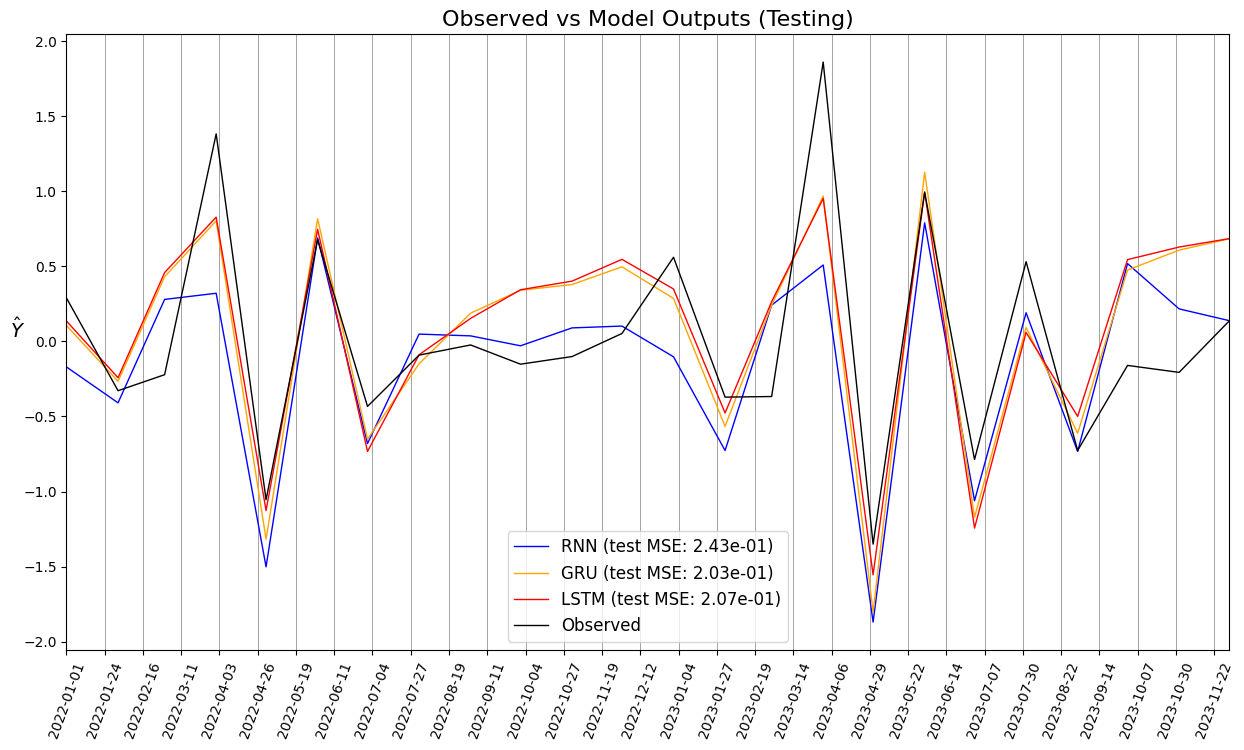

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

compare = params.keys()  # Ejemplo: ['rnn', 'alpharnn'] o ['lstm']
l, u = (None, None)  # Índices inferiores y superiores del rango a graficar
ds = max(1, len(y_test[l:u]) // max_pts)  # Relación de submuestreo para `max_pts`

fig = plt.figure(figsize=(15, 8))
x_vals = np.array(y_test_timestamps[l:u:ds])  # Convertir a numpy array
for key in compare:
    y_vals = np.array(params[key]['pred_test'][l:u:ds])  # Convertir a numpy array
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, np.array(y_test[l:u:ds]), c="black", label="Observed", lw=1)

# Convertimos numpy.datetime64 a datetime para trabajar con timedelta
start, end = np.datetime64(x_vals.min(), 'D').astype('datetime64[D]').astype('O'), \
             np.datetime64(x_vals.max(), 'D').astype('datetime64[D]').astype('O')

# Calculamos los xticks
xticks = [start + timedelta(days=i) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks) // 30)]
for t in xticks:
    plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16)
plt.show()


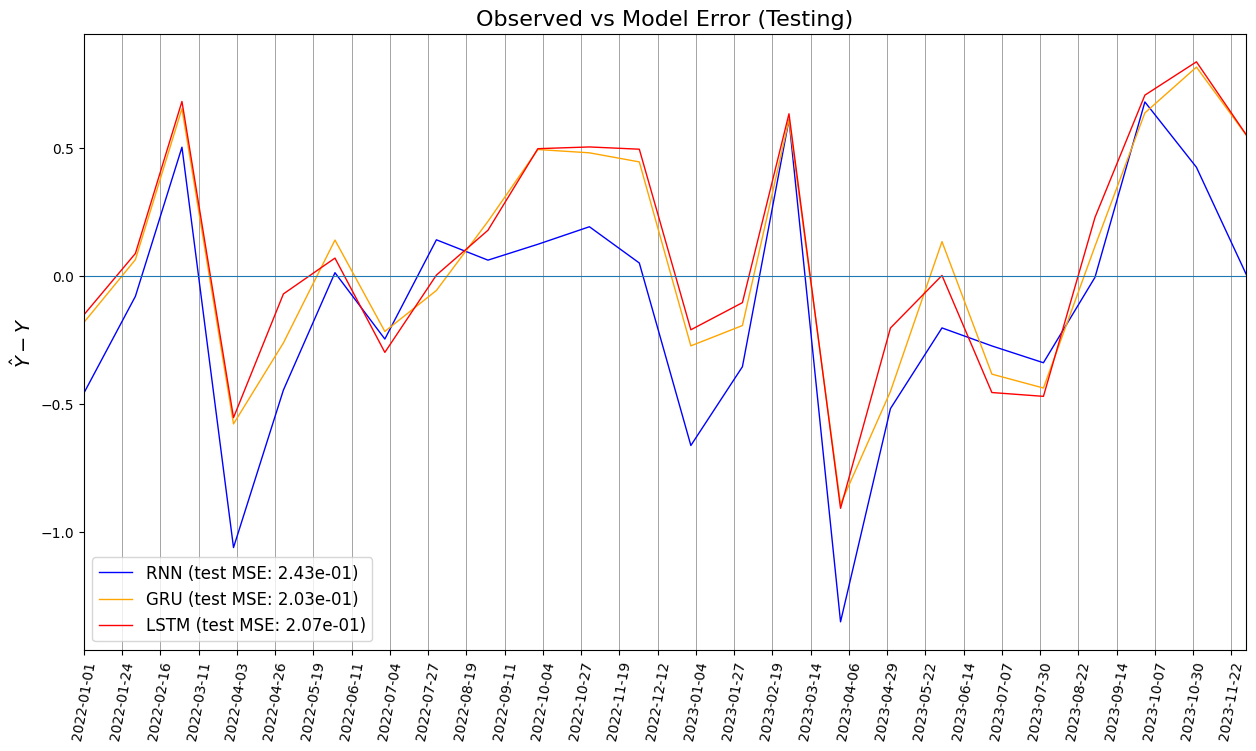

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

compare = params.keys()  # Ejemplo: ['rnn', 'alpharnn'] o ['lstm']
l, u = (None, None)  # Índices inferiores y superiores del rango a graficar
ds = max(1, len(y_train[l:u]) // max_pts)  # Relación de submuestreo para `max_pts`

fig = plt.figure(figsize=(15, 8))
x_vals = np.array(y_test_timestamps[l:u:ds])  # Convertir a numpy array
for key in compare:
    y_vals = np.array(params[key]['pred_test'][l:u:ds]) - np.array(y_test[l:u:ds])  # Convertir a numpy array
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)

# Convertimos numpy.datetime64 a datetime para trabajar con timedelta
start, end = np.datetime64(x_vals.min(), 'D').astype('datetime64[D]').astype('O'), \
             np.datetime64(x_vals.max(), 'D').astype('datetime64[D]').astype('O')

# Calculamos los xticks
xticks = [start + timedelta(days=i) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks) // 30)]
plt.axhline(0, linewidth=0.8)
for t in xticks:
    plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=80)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Testing)', fontsize=16)
plt.show()


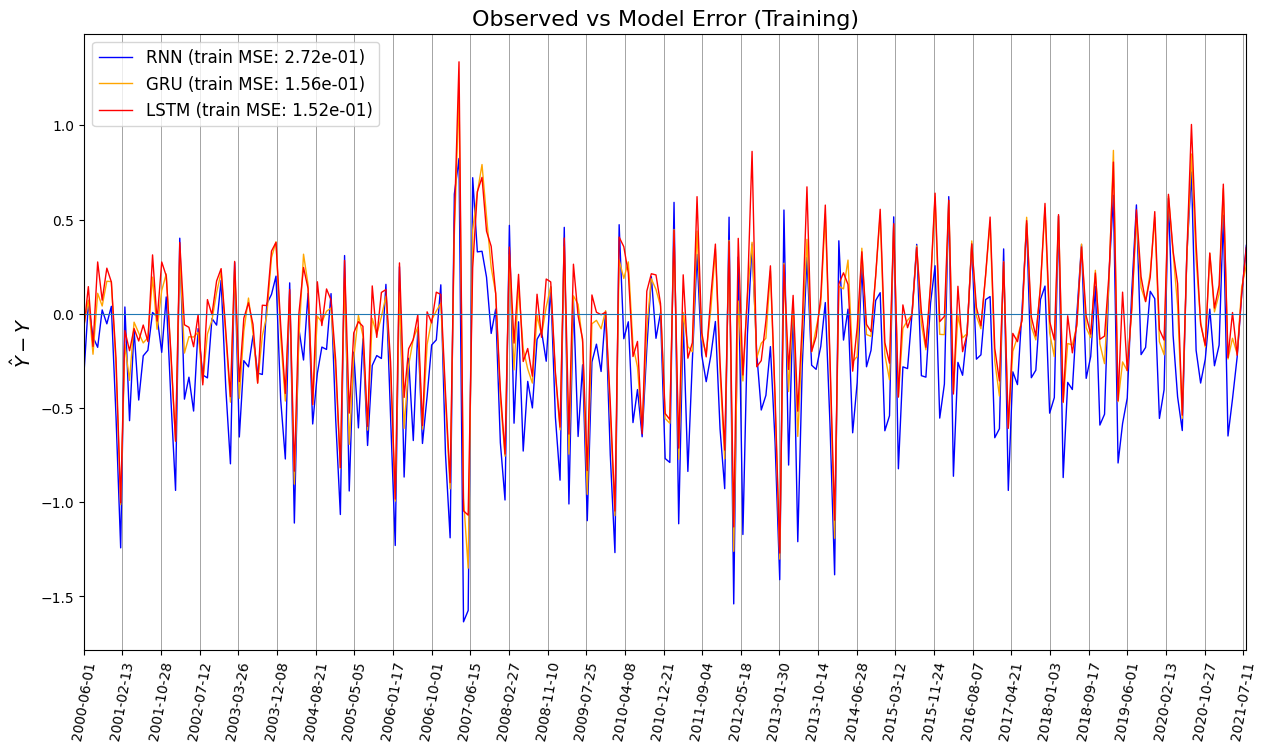

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

compare = params.keys()  # Ejemplo: ['rnn', 'alpharnn'] o ['lstm']
l, u = (None, None)  # Índices inferiores y superiores del rango a graficar
ds = max(1, len(y_train[l:u]) // max_pts)  # Relación de submuestreo para `max_pts`

fig = plt.figure(figsize=(15, 8))
x_vals = np.array(y_train_timestamps[l:u:ds])  # Convertir a numpy array
for key in compare:
    y_vals = np.array(params[key]['pred_train'][l:u:ds]) - np.array(y_train[l:u:ds])  # Convertir a numpy array
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)

# Convertimos numpy.datetime64 a datetime para trabajar con timedelta
start, end = np.datetime64(x_vals.min(), 'D').astype('datetime64[D]').astype('O'), \
             np.datetime64(x_vals.max(), 'D').astype('datetime64[D]').astype('O')

# Calculamos los xticks
xticks = [start + timedelta(days=i) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks) // 30)]
plt.axhline(0, linewidth=0.8)
for t in xticks:
    plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=80)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Training)', fontsize=16)
plt.show()

In [113]:
print(compare)

dict_keys(['rnn', 'gru', 'lstm'])


In [114]:
predLSTM=params['lstm']['pred_test']
predRNN=params['rnn']['pred_test']
predGRU=params['gru']['pred_test']

In [115]:
### Des - Normalizando
predLSTM=(predLSTM + mu)*sigma
predRNN=(predRNN + mu)*sigma
predGRU=(predGRU + mu)*sigma

In [116]:
### Funcion correcta para volver a los valores originales
def diferencia(n,x,dif):
  vector=np.array([x])
  for i in range(0,n):
    a=vector[0]
    b=dif[i]
    res=vector[i]+b
    vector=np.append(vector,res)
  return(vector)

In [117]:
Models=pd.DataFrame(np.exp(diferencia(16,15.947456,predLSTM)), index=indice[271:], columns=['PredLSTM'])
Models['PredRNN']=np.exp(diferencia(16,15.947456,predRNN))
Models['PredGRU']=np.exp(diferencia(16,15.947456,predGRU))
print(Models.head(8))

                PredLSTM       PredRNN       PredGRU
2022-08-01  8.431253e+06  8.431253e+06  8.431253e+06
2022-09-01  9.326838e+06  7.533737e+06  9.135021e+06
2022-10-01  7.928557e+06  5.698251e+06  7.636221e+06
2022-11-01  1.098706e+07  6.971297e+06  1.037741e+07
2022-12-01  1.970740e+07  8.776213e+06  1.829826e+07
2023-01-01  9.035675e+06  3.096407e+06  7.341421e+06
2023-02-01  1.531393e+07  5.043116e+06  1.306940e+07
2023-03-01  9.241662e+06  3.156106e+06  8.349695e+06


In [118]:
Models['Observed'] = RENTAdf['I_Renta'].iloc[271:].values
print(Models)

                PredLSTM       PredRNN       PredGRU      Observed
2022-08-01  8.431253e+06  8.431253e+06  8.431253e+06  8.431256e+06
2022-09-01  9.326838e+06  7.533737e+06  9.135021e+06  8.369634e+06
2022-10-01  7.928557e+06  5.698251e+06  7.636221e+06  7.598283e+06
2022-11-01  1.098706e+07  6.971297e+06  1.037741e+07  7.147080e+06
2022-12-01  1.970740e+07  8.776213e+06  1.829826e+07  7.484052e+06
2023-01-01  9.035675e+06  3.096407e+06  7.341421e+06  1.117054e+07
2023-02-01  1.531393e+07  5.043116e+06  1.306940e+07  8.700591e+06
2023-03-01  9.241662e+06  3.156106e+06  8.349695e+06  6.796042e+06
2023-04-01  8.740005e+06  3.286087e+06  7.572808e+06  2.513462e+07
2023-05-01  9.790862e+06  3.393281e+06  8.690726e+06  9.884491e+06
2023-06-01  1.252825e+07  3.346052e+06  1.109518e+07  1.996735e+07
2023-07-01  1.668779e+07  3.585961e+06  1.454433e+07  1.163436e+07
2023-08-01  2.459447e+07  3.875825e+06  2.070608e+07  1.701048e+07
2023-09-01  3.158444e+07  3.631360e+06  2.545143e+07  1.033816

In [119]:
indice2=pd.date_range(start='8/01/2022', periods=17, freq='MS')
indice2

DatetimeIndex(['2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01',
               '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01',
               '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01',
               '2023-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [120]:
Models['time'] = indice2
print(Models)

                PredLSTM       PredRNN       PredGRU      Observed       time
2022-08-01  8.431253e+06  8.431253e+06  8.431253e+06  8.431256e+06 2022-08-01
2022-09-01  9.326838e+06  7.533737e+06  9.135021e+06  8.369634e+06 2022-09-01
2022-10-01  7.928557e+06  5.698251e+06  7.636221e+06  7.598283e+06 2022-10-01
2022-11-01  1.098706e+07  6.971297e+06  1.037741e+07  7.147080e+06 2022-11-01
2022-12-01  1.970740e+07  8.776213e+06  1.829826e+07  7.484052e+06 2022-12-01
2023-01-01  9.035675e+06  3.096407e+06  7.341421e+06  1.117054e+07 2023-01-01
2023-02-01  1.531393e+07  5.043116e+06  1.306940e+07  8.700591e+06 2023-02-01
2023-03-01  9.241662e+06  3.156106e+06  8.349695e+06  6.796042e+06 2023-03-01
2023-04-01  8.740005e+06  3.286087e+06  7.572808e+06  2.513462e+07 2023-04-01
2023-05-01  9.790862e+06  3.393281e+06  8.690726e+06  9.884491e+06 2023-05-01
2023-06-01  1.252825e+07  3.346052e+06  1.109518e+07  1.996735e+07 2023-06-01
2023-07-01  1.668779e+07  3.585961e+06  1.454433e+07  1.163436e+

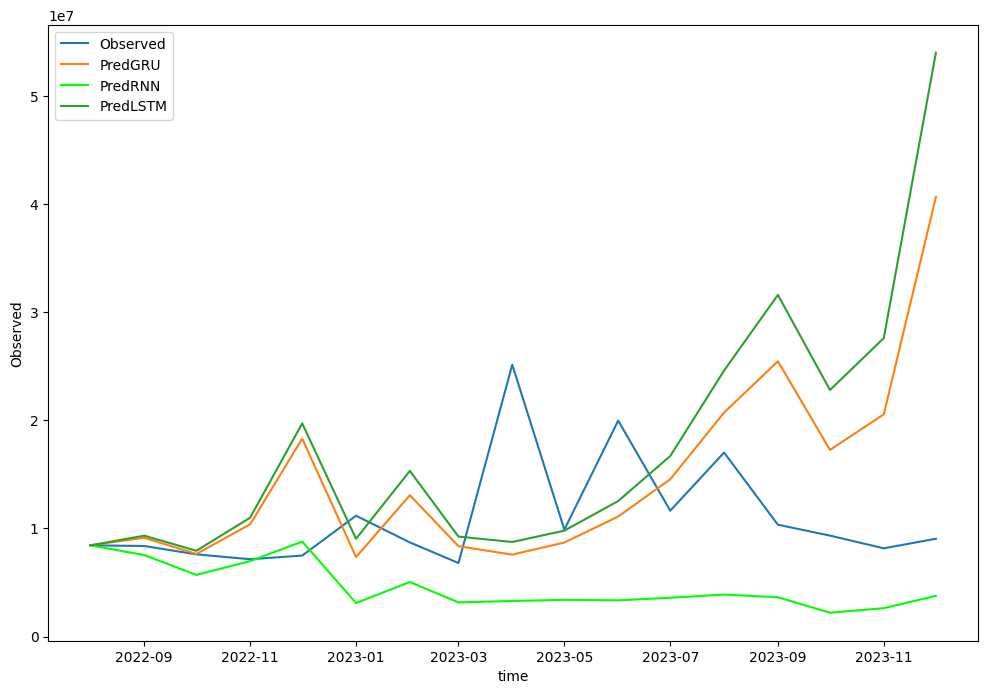

In [121]:
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.lineplot(data=Models, x="time", y="Observed", label="Observed")
sns.lineplot(data=Models, x="time", y="PredGRU", label="PredGRU")
sns.lineplot(data=Models, x="time", y="PredRNN", label="PredRNN",  color="lime")
sns.lineplot(data=Models, x="time", y="PredLSTM", label="PredLSTM")
plt.show()

In [122]:
### RMSE Modelo RNN
mse = mean_squared_error(Models['Observed'].values, Models['PredRNN'].values)

# Calcular el RMSE
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 75599420039985.38
RMSE: 8694792.696780376


In [123]:
### RMSE Modelo GRU
mse = mean_squared_error(Models['Observed'].values, Models['PredGRU'].values)

# Calcular el RMSE
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 118717041075223.33
RMSE: 10895734.994722629


In [124]:
### RMSE Modelo LSTM
mse = mean_squared_error(Models['Observed'].values, Models['PredLSTM'].values)

# Calcular el RMSE
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 215101910720189.9
RMSE: 14666353.013622368
